In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import *

import matplotlib.pyplot as plt
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix

In [3]:
path = '/home/ubuntu/Data/AOI_training/'
categories = ['Good_parts', 'Bad_parts']

In [ ]:
def split_val_data(split_rate=0.2):
    val_path = path + "valid/"
    train_path = path + "train/"

    print(val_path)
    if os.path.exists(val_path):
        return False
    else:
        # make validation data set path
        os.mkdir(val_path)

        for cat in categories:
            print(cat)
            os.mkdir(val_path + cat)

            train_path_name = os.listdir(train_path + cat)
            # shuffling files
            random.shuffle(train_path_name)

            # split data set
            to_val = train_path_name[:int(len(train_path_name) * split_rate)]

            for f in to_val:
                shutil.move(os.path.join(train_path, cat, f), os.path.join(val_path, cat))

        return True

In [ ]:
# split train/val data
split_data = True  # just done with once at initial time
if split_data:
    split_val_data()

In [ ]:
arch=resnet50
sz = 256
bs = 64

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2, crop_type=CropType.NO)
#data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)
data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs)

In [ ]:
plt.imshow(load_img_id(data.val_ds, 1, path))
plt.show()

In [ ]:
y = data.trn_ds.y

In [ ]:
print(y[:10])

In [ ]:
from collections import Counter

num_train = 0
label_counts = Counter(y).most_common()
for l, c in label_counts:
    num_train = num_train + c
    print(c, '\t', data.classes[l])
    
print(num_train)

In [ ]:
for label in sorted([l for l, c in label_counts], key=lambda p: data.classes[p]):
    i = [i for i, l in enumerate(y) if l == label][0]
    print(data.classes[y[i]])
    plt.imshow(load_img_id(data.trn_ds, i, path))
    plt.show()

In [ ]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = path + '/train/Bad_parts'

files = os.listdir(folder)
sizes = []

for file in files:
    filename = os.path.join(folder, file)
    img = cv2.imread(filename, flags)
    sizes.append(max(img.shape[0], img.shape[1]))

In [ ]:
plt.hist(sizes, bins=50)
plt.show()

In [ ]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = path + '/train/Bad_parts'

files = os.listdir(folder)
for i in range(5):
    f = plt.figure(figsize=(5, 5))
    
    filename = os.path.join(folder, files[i])
    img = cv2.imread(filename, flags)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    sp = f.add_subplot(1, 2, 1)
    plt.imshow(img)
    
    img = np.concatenate([np.expand_dims(cv2.equalizeHist(img[:,:,i]), axis=2) for i in range(3)], axis=2)
    
    
    sp = f.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.show()
    
    print(img.shape)

#Image Augmentation

In [4]:
# Look at examples of image augmentation
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [5]:
arch=resnet50
sz = 256
bs = 64

#aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=None, max_zoom=1.2, crop_type=CropType.NO)
#tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)
#data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs)

#ims = np.stack([get_augs() for i in range(6)])
#plots(ims, rows=2)

In [6]:
# Create a learner
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [7]:
wd=5e-4

In [ ]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.learn.lr_find()
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.006, 0.01))

In [ ]:
learn

In [ ]:
def fbeta(log_preds, targs, beta=1, thresh=0.5, epsilon=1e-8):
    """Calculates the F-beta score (the weighted harmonic mean of precision and recall).
    This is the micro averaged version where the true positives, false negatives and
    false positives are calculated globally (as opposed to on a per label basis).

    beta == 1 places equal weight on precision and recall, b < 1 emphasizes precision and
    beta > 1 favors recall.
    """
    assert beta > 0, 'beta needs to be greater than 0'
    beta2 = beta ** 2
    rec = recall(log_preds, targs, thresh)
    prec = precision(log_preds, targs, thresh)
    return (1 + beta2) * prec * rec / (beta2 * prec + rec + epsilon)

In [ ]:
learn.metrics = [fbeta]

In [ ]:
learn.fit(0.01, 3, wds=wd)

In [ ]:
learn.save('precompute')

In [ ]:
learn.fit(0.01, 1, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
learn.save('pre_cycle')

In [8]:
learn.load('pre_cycle')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.0025, 0.01))

In [ ]:
#learn.unfreeze()
learn.fit(1e-4, 1, wds=wd)
#learn.fit(0.01, 3)

In [ ]:
learn.save('unfreeze1')

In [ ]:
learn.load('unfreeze1')

In [ ]:
lr=1e-3

In [ ]:
learn.fit(lr, 1, cycle_len=1, cycle_mult=2, wds=wd)
#learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('unfreeze_cycle')

In [9]:
log_preds,y = learn.predict_with_targs()
preds = np.exp(log_preds)
pred_labels = np.argmax(preds, axis=1)

[[1297  203]
 [  44 3635]]


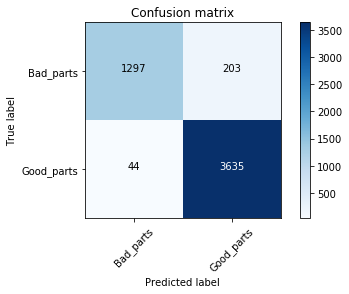

In [10]:
cm = confusion_matrix(y, pred_labels)
plot_confusion_matrix(cm, data.classes)

In [ ]:
results = ImageModelResults(data.val_ds, log_preds)

### Most incorrect

In [ ]:
incorrect = [i for i in range(len(pred_labels)) if pred_labels[i] != y[i]]
c = Counter([(y[i], data.classes[y[i]]) for i in incorrect])
c.most_common(20)

In [ ]:
results.plot_most_incorrect(0)

In [ ]:
results.plot_most_incorrect(1)

### Most correct

In [ ]:
results.plot_most_correct(0)

In [ ]:
results.plot_most_correct(1)

In [ ]:
results.plot_most_correct(1)

### Most uncertain

In [ ]:
results.plot_most_uncertain(1)

In [ ]:
results.plot_most_uncertain(0)

## Test time augmentation (TTA)

In [ ]:
log_preds,y = learn.TTA(n_aug=20)
preds = np.mean(np.exp(log_preds),0)

In [ ]:
preds

In [ ]:
y

In [ ]:
accuracy_np(preds, y)

In [ ]:
accuracy_np(preds, y), metrics.log_loss(y, preds)

In [ ]:
import torch
log_preds_tensor = torch.Tensor(log_preds)
y_tensor = torch.Tensor(y)
print(log_preds_tensor.shape)
y_tensor.shape

In [ ]:
# preds = np.argmax(preds, 1)
precision_np(preds, y)

In [ ]:
from sklearn.metrics import f1_score

def f1(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([f1_score(targs, (preds>th), average='weighted')
                    for th in np.arange(start,end,step)])

In [ ]:
f1(preds, y)

In [ ]:
fbeta_np(preds, y, 1)

In [ ]:
preds = np.argmax(preds, axis=1)
print(preds.shape)
print(preds)
print(preds.shape)

In [9]:
test_log_predictions, _ = learn.TTA(n_aug=1, is_test=True)
test_probs = np.mean(np.exp(test_log_predictions),0)
test_predictions = np.argmax(test_probs, axis=1)
print(test_predictions.shape)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
test_file_names = learn.data.test_ds.fnames

(3575,)                                      


In [19]:
result = []
for index, prob in enumerate(test_probs):
    result.append(prob[test_predictions[index]])
print(result)

[0.987242, 0.99331796, 0.99936116, 0.9996672, 0.9948002, 0.9681766, 0.9948558, 0.86251855, 0.94140655, 0.9962136, 0.9986472, 0.9999838, 0.98548436, 0.99456316, 0.9985995, 0.8146988, 0.9961665, 0.99916184, 0.87788546, 0.99988127, 0.9256722, 0.9995055, 0.8345419, 0.9973153, 0.9999771, 0.6445489, 0.9961734, 0.99358624, 0.9851444, 0.9995129, 0.99354935, 0.81838214, 0.9940395, 0.9762045, 0.99916977, 0.9603267, 0.9913495, 0.79754204, 0.9728723, 0.73799306, 0.99513453, 0.8221834, 0.99712086, 0.885635, 0.94555056, 0.9900135, 0.97269535, 0.99897885, 0.97891235, 0.99944687, 0.9978705, 0.9915447, 0.9967751, 0.6834018, 0.9998193, 0.9999285, 0.64417696, 0.9978036, 0.9509615, 0.99260914, 0.9997087, 0.9753538, 0.9766253, 0.50702244, 0.98077154, 0.9883957, 0.9865974, 0.988352, 0.98829246, 0.9105094, 0.92463505, 0.98487103, 0.98214006, 0.9980011, 0.9990518, 0.97726613, 0.9979482, 0.98526156, 0.99284524, 0.9957987, 0.7762456, 0.9931276, 0.9396199, 0.9975899, 0.99852073, 0.99670786, 0.99973655, 0.9849891

In [22]:
with open('submission_AOI_prob.csv', 'w') as the_file:
    for file_path, prediction, res in zip(test_file_names, test_predictions_classes, result):
        print(file_path)
        file_name = file_path.split('/')[-1].split(".")[0]
        the_file.write(file_name)
        the_file.write(",")
        if prediction == "Good_parts":
            the_file.write("2")
        else:
            the_file.write("1")
        the_file.write(",")
        the_file.write(str(res))
        the_file.write("\n")
the_file.close()

#from IPython.display import FileLink
#FileLink('submission.csv')

test/A3C0120130100000000000000037500C3002S_20181018125005_XM03_VRF__C1863-2_9001.png
test/A3C0120130100000000000000038520C3002S_20181023122908_XM03_VRF__C1857-1_9001.png
test/A2C122548050000016407C060400000S_20180516220511_XM01_VRF__C2003-2_9001.png
test/A2C1706220200000000000001930530C1103S_20181119161329_XM03_VRF__C3185-2_9001.png
test/A2C1615840200004201061812072911G0505S_20180601122259_SI21_VRF__C0408-1_9001.png
test/8138310200017101802043111C0503S_20181017023632_XM02_VRF__C8561-3_9001.png
test/9855790102205051811221911C0506S_20180505113930_XM01_VRF__C549-2_9001.png
test/A2C1780550200000000000000191060C2202B_20180604165805_XM03_VRF__C1810-1_9001.png
test/A2C1656660200000000000001065730C0204S_20180603143939_XM03_VRF__C0637-1_9001.png
test/A2C1885700000000006071820510711G0505B_20180709003005_CM33_VRF__C2231-2_9001.png
test/A2C1706290200000000000001163430C1103S_20181012161015_XM03_VRF__C3184-2_9001.png
test/A2C1706220200000000000001363080C1103S_20181024090805_XM03_VRF__C3183-1_9001.pn

test/9855790102214051816390811C0506S_20180514165718_XM01_VRF__C549-2_9001.png
test/9855790102206061810052811C0506S_20180606110425_XM01_VRF__C549-1_9001.png
test/A2C1706300200000000000001229610C1103S_20181016044812_XM03_VRF__C3184-3_9001.png
test/A2C1616120200000006081813262911G0505B_20180807024623_CM33_VRF__C0512-1_9001.png
test/8138310200005111823243211C0503S_20181106002428_XM02_VRF__C8561-2_9001.png
test/A2C1706310200000000000001180080C1103S_20181013061716_XM03_VRF__C3183-3_9001.png
test/A2C1706270200000000000001201290C1103S_20181015070957_XM03_VRF__C3183-2_9001.png
test/A2C1512200000014272712018072411B_20180726125112_SI23_VRF__C1113-3_9001.png
test/A2C1656660100000000000001388740C0203S_20180508085322_XM03_VRF__C0631-1_9001.png
test/A2C1512320000014890592018081311S_20180813185032_CM29_VRF__C1190-1_9001.png
test/A2C1615840200004202051821565011G0505S_20180502233808_SI21_VRF__C0408-2_9001.png
test/A2C122548060000034883C060600000S_20181027101703_SI22_VRF__C1411-2_9001.png
test/A2C1616720

In [11]:
with open('submission.csv', 'w') as the_file:
    for file_path, prediction in zip(test_file_names, test_predictions_classes):
        print(file_path)
        file_name = file_path.split('/')[-1].split(".")[0]
        the_file.write(file_name)
        the_file.write(",")
        if prediction == "Good_parts":
            the_file.write("2")
        else:
            the_file.write("1")
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission.csv')

test/A3C0120130100000000000000037500C3002S_20181018125005_XM03_VRF__C1863-2_9001.png
test/A3C0120130100000000000000038520C3002S_20181023122908_XM03_VRF__C1857-1_9001.png
test/A2C122548050000016407C060400000S_20180516220511_XM01_VRF__C2003-2_9001.png
test/A2C1706220200000000000001930530C1103S_20181119161329_XM03_VRF__C3185-2_9001.png
test/A2C1615840200004201061812072911G0505S_20180601122259_SI21_VRF__C0408-1_9001.png
test/8138310200017101802043111C0503S_20181017023632_XM02_VRF__C8561-3_9001.png
test/9855790102205051811221911C0506S_20180505113930_XM01_VRF__C549-2_9001.png
test/A2C1780550200000000000000191060C2202B_20180604165805_XM03_VRF__C1810-1_9001.png
test/A2C1656660200000000000001065730C0204S_20180603143939_XM03_VRF__C0637-1_9001.png
test/A2C1885700000000006071820510711G0505B_20180709003005_CM33_VRF__C2231-2_9001.png
test/A2C1706290200000000000001163430C1103S_20181012161015_XM03_VRF__C3184-2_9001.png
test/A2C1706220200000000000001363080C1103S_20181024090805_XM03_VRF__C3183-1_9001.pn

test/A2C1186070100000015061812180211F3506S_20180615123341_CM33_VRF__C0414-1_9001.png
test/A2C1899050000000013071801305511G0505B_20180713105257_CM33_VRF__C0515-2_9001.png
test/A2C1301060260002424866888888888B_20180724011314_SI23_VRF__C3011-3_9001.png
test/9855790202221091810355411C0507S_20180921105035_SI22_VRF__C549-2_9001.png
test/A2C1512320000014887862018081311S_20180813171530_CM29_VRF__C1075-1_9001.png
test/A2C1616120200000016111805311911G0505S_20181116055045_CM33_VRF__C2252-1_9001.png
test/A2C1706270200000000000001855740C1103S_20181115195616_XM03_VRF__C2252-2_9001.png
test/9855790102205051811483121C0506S_20180505121028_XM01_VRF__C549-1_9001.png
test/A2C1706270200000000000000451470C1103S_20180810230042_XM03_VRF__C3186-2_9001.png
test/A2C1693540300000000372018072311S_20180723212611_SI23_VRF__C2107-2_9001.png
test/A2C122548050000015147C060400000S_20180509003201_XM01_VRF__C1919-1_9001.png
test/9855790102202051800561611C0506S_20180502012347_XM01_VRF__C549-1_9001.png
test/A2C1656660200000

/home/ubuntu/srieraam/F2ST1/submission.csv

In [ ]:
# Retrain on the training set + validation set

In [ ]:
from collections import Counter

def winner(input): 
  
     # convert list of candidates into dictionary 
     # output will be likes candidates = {'A':2, 'B':4} 
     votes = Counter(input)
     #print(votes)
       
     # create another dictionary and it's key will 
     # be count of votes values will be name of  
     # candidates 
     dict = {} 
  
     for value in votes.values(): 
  
          # initialize empty list to each key to  
          # insert candidate names having same  
          # number of votes  
          dict[value] = [] 
  
     for (key,value) in votes.items(): 
          dict[value].append(key) 
  
     # sort keys in descending order to get maximum  
     # value of votes 
     maxVote = sorted(dict.keys(),reverse=True)[0] 
  
     # check if more than 1 candidates have same  
     # number of votes. If yes, then sort the list 
     # first and print first element 
     if len(dict[maxVote])>1:
         return sorted(dict[maxVote])[0]
     else:
         return dict[maxVote][0]

In [ ]:
import pandas as pd

submission1 = './submission23.csv'
submission2 = './submission22.csv'
submission3 = './submission21.csv'
submission4 = './submission18.csv'
submission5 = './submission17.csv'
submission6 = './submission17.csv'
submission7 = './submission16.csv'

counter = 0

df1 = pd.read_csv(submission1)
df2 = pd.read_csv(submission2)
df3 = pd.read_csv(submission3)
df4 = pd.read_csv(submission4)
df5 = pd.read_csv(submission5)
df6 = pd.read_csv(submission6)
df7 = pd.read_csv(submission7)

classes = []
speciesList = []

for i in range(0, len(df1)):
    classes.append(winner([df1['species'][i], df2['species'][i], df3['species'][i], df4['species'][i], df5['species'][i], df6['species'][i], df7['species'][i]]))

with open('submission.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission.csv')

In [ ]:
# Testing on the test set

In [ ]:
true_test_labels = {a.filename: a.label for a in test_annotations}
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(true_test_labels[filename]) for filename in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
log_preds = learn.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

In [ ]:
log_preds,_ = learn.TTA(n_aug=20, is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)